## LSTMs
This workbook contains all the different classes of LSTMs that can be used as building blocks for extensive use cases. Inspired by https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=jKq3eAIvH4Db 

In [1]:
#testing out the window gen function for ts in LSTM
import numpy as np
from numpy import fft
import pandas as pd
from scipy import signal as sig
from cmath import phase
import math
# from window_generator import WindowGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
from fft_utils import FFTFeatureExtractor
import tensorflow as tf
from sklearn.linear_model import LinearRegression

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# NYC taxi dataset
train_df = pd.read_csv('../sample-data/train/train.csv')
test_df = pd.read_csv('../sample-data/test/test.csv')

Data fields:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [3]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.store_and_fwd_flag = train_df.store_and_fwd_flag.apply(lambda x: 1 if x=='Y' else 0)

In [4]:
ts_train = train_df.groupby(pd.Grouper(key='pickup_datetime', freq='T'))[['passenger_count','trip_duration']].sum().reset_index()
ts_train['time_min'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()/60
ts_train['time_sec'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()

In [5]:
date_time = ts_train.pop('pickup_datetime')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60

ts_train['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ts_train['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
ts_train['pass_count_standardized'] = (ts_train['passenger_count'] - np.mean(ts_train['passenger_count'])) / np.std(ts_train['passenger_count'])
ts_train['trip_duration_truncated'] = ts_train.trip_duration.apply(lambda x: min(14000, x))
ts_train['trip_duration_std'] = (ts_train.trip_duration_truncated - np.mean(ts_train.trip_duration_truncated)) / np.std(ts_train.trip_duration_truncated)
ts_train

passenger_count  trip_duration  time_min    time_sec       day_sin  \
0                     6           2143       0.0         0.0 -2.008887e-10   
1                    11           3454       1.0        60.0  2.588190e-01   
2                     2           1755       2.0       120.0  5.000000e-01   
3                     3           2417       3.0       180.0  7.071068e-01   
4                     8           1291       4.0       240.0  8.660254e-01   
...                 ...            ...       ...         ...           ...   
262075               16           8370  262075.0  15724500.0 -9.659258e-01   
262076               13           5824  262076.0  15724560.0 -8.660254e-01   
262077                9           6750  262077.0  15724620.0 -7.071068e-01   
262078               10           5893  262078.0  15724680.0 -5.000000e-01   
262079               10           7351  262079.0  15724740.0 -2.588190e-01   

         day_cos  pass_count_standardized  trip_duration_truncated  \
0       1.000000                -0.495907                     2143   
1       0.965926                 0.263713                     3454   
2       0.866025                -1.103604                     1755   
3       0.707107                -0.951680                     2417   
4       0.500000                -0.192059                     1291   
...          ...                      ...                      ...   
262075  0.258819                 1.023333                     8370   
262076  0.500000                 0.567561                     5824   
262077  0.707107                -0.040135                     6750   
262078  0.866025                 0.111789                     5893   
262079  0.965926                 0.111789                     7351   

        trip_duration_std  
0               -0.739953  
1               -0.359686  
2               -0.852496  
3               -0.660477  
4               -0.987083  
...                   ...  
262075           1.066243  
262076           0.327754  
262077           0.596348  
262078           0.347768  
262079           0.770673  

[262080 rows x 9 columns]

In [6]:
np.percentile(ts_train.trip_duration, 99)

17334.839999999967

## Adding in the FFT features on here

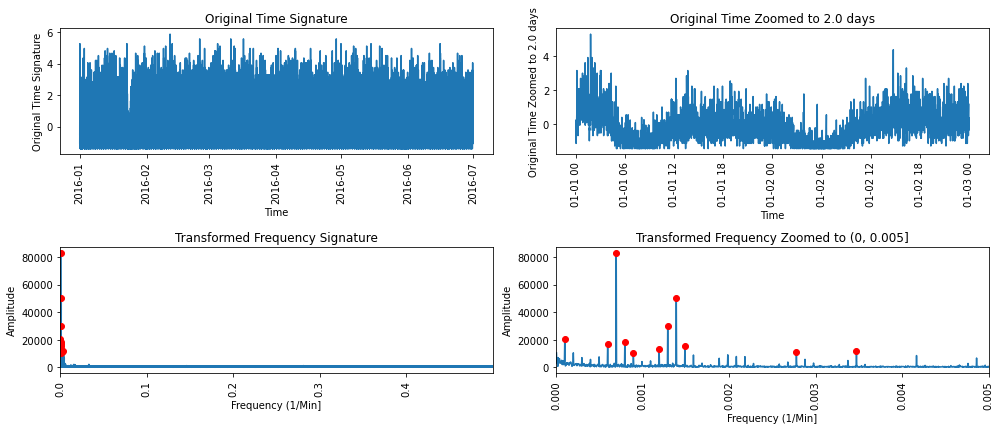

In [7]:
fftExtract = FFTFeatureExtractor(ts_train['pass_count_standardized'], time_series=date_time)
fftExtract.fft_transform(freqlim_max=.005, timelim_max=48*60)

In [8]:
x = fftExtract.frequency_table_viewer()
x

index  freq (1/min)     amplitude  period (days)  \
2     182      0.000694  83129.120703       1.000000   
7     364      0.001389  50464.065795       0.500000   
6     338      0.001290  30235.316117       0.538462   
0      26      0.000099  20405.092830       7.000000   
3     208      0.000794  18152.144782       0.875000   
1     156      0.000595  16850.799015       1.166667   
8     390      0.001488  15177.829631       0.466667   
5     312      0.001190  13107.076583       0.583333   
10    910      0.003472  12192.004321       0.200000   
9     728      0.002778  11290.985209       0.250000   
4     234      0.000893  10563.075923       0.777778   

                           fft  
2  -19025.269777+80922.739812j  
7   20353.750914+46177.340333j  
6   25628.566729+16042.160332j  
0    18367.142717-8889.087793j  
3   11904.160193-13703.697687j  
1    7611.043881+15034.009395j  
8   -13298.138668-7316.147912j  
5   -10193.657445+8239.223533j  
10   3243.886772+11752.538789j  
9   -4843.691706-10199.264564j  
4  -8516.3690240-6249.0024490j

In [9]:
filtered_residuals = fftExtract.ifft_transform()

In [10]:
# validation check
fftExtract.fourier_terms_df_creator()
decomposedResult = fftExtract.decompose_df_into_pure_freq(signal=ts_train['pass_count_standardized'], time_min= ts_train['time_min']  )

In [11]:
decomposedResult.head()

pass_count_standardized  time_min          FT_1          FT_2  \
0                -0.495907       0.0 -19025.269777  20353.750914   
1                 0.263713       1.0 -19378.179612  19950.007706   
2                -1.103604       2.0 -19730.720514  19544.745228   
3                -0.951680       3.0 -20082.885773  19137.994341   
4                -0.192059       4.0 -20434.668681  18729.786022   

           FT_3          FT_4          FT_5         FT_6          FT_7  \
0  25628.566729  18367.142717  11904.160193  7611.043881 -13298.138668   
1  25497.732054  18372.680000  11972.347514  7554.763719 -13229.152571   
2  25365.223113  18378.210145  12040.237123  7498.377884 -13159.009961   
3  25231.048607  18383.733149  12107.827330  7441.887166 -13087.716972   
4  25095.217345  18389.249010  12175.116457  7385.292354 -13015.279836   

           FT_8         FT_9        FT_10        FT_11        FT_All  
0 -10193.657445  3243.886772 -4843.691706 -8516.369024  31231.424586  
1 -10255.000952  2986.734532 -4664.952277 -8481.178373  30325.801741  
2 -10315.770692  2728.160768 -4484.791859 -8445.720804  29418.940430  
3 -10375.963266  2468.288548 -4303.265331 -8409.997432  28510.950368  
4 -10435.575306  2207.241556 -4120.427985 -8374.009381  27601.941554

In [12]:
decomposedResult['FT_All_Std'] = (decomposedResult['FT_All'] - np.mean(decomposedResult['FT_All'])) / np.std(decomposedResult['FT_All'])
decomposedResult['pass_count_std-FT_All_Std'] = (decomposedResult['pass_count_standardized'] - decomposedResult['FT_All_Std'])

In [13]:
print("Mean and standard deviation of standardized passenger count")
print(np.mean(decomposedResult['pass_count_standardized']), np.std(decomposedResult['pass_count_standardized']))
print("Mean and standard deviation of standardized passenger count subtract standardized total frequency")
print(np.mean(decomposedResult['pass_count_std-FT_All_Std']), np.std(decomposedResult['pass_count_std-FT_All_Std']))

print("Mean and standard deviation of Inverse FTT-transformed peaks of FFT-transformed standardized passenger counts")
print(np.mean(filtered_residuals), np.std(filtered_residuals))

Mean and standard deviation of standardized passenger count
-8.54271713740034e-15 1.0000000000000255
Mean and standard deviation of standardized passenger count subtract standardized total frequency
2.8224946460899315e-16 0.8991119649098855
Mean and standard deviation of Inverse FTT-transformed peaks of FFT-transformed standardized passenger counts
(1.518253708889103e-18-4.120974352698994e-18j) 0.42129339806236177


In [14]:
gold_train_table = decomposedResult.merge(ts_train, left_on=['time_min', 'pass_count_standardized'], right_on=['time_min', 'pass_count_standardized'])
gold_train_table.head()

pass_count_standardized  time_min          FT_1          FT_2  \
0                -0.495907       0.0 -19025.269777  20353.750914   
1                 0.263713       1.0 -19378.179612  19950.007706   
2                -1.103604       2.0 -19730.720514  19544.745228   
3                -0.951680       3.0 -20082.885773  19137.994341   
4                -0.192059       4.0 -20434.668681  18729.786022   

           FT_3          FT_4          FT_5         FT_6          FT_7  \
0  25628.566729  18367.142717  11904.160193  7611.043881 -13298.138668   
1  25497.732054  18372.680000  11972.347514  7554.763719 -13229.152571   
2  25365.223113  18378.210145  12040.237123  7498.377884 -13159.009961   
3  25231.048607  18383.733149  12107.827330  7441.887166 -13087.716972   
4  25095.217345  18389.249010  12175.116457  7385.292354 -13015.279836   

           FT_8  ...        FT_All  FT_All_Std  pass_count_std-FT_All_Std  \
0 -10193.657445  ...  31231.424586    0.400026                  -0.895933   
1 -10255.000952  ...  30325.801741    0.388426                  -0.124713   
2 -10315.770692  ...  29418.940430    0.376811                  -1.480415   
3 -10375.963266  ...  28510.950368    0.365181                  -1.316861   
4 -10435.575306  ...  27601.941554    0.353538                  -0.545597   

   passenger_count  trip_duration  time_sec       day_sin   day_cos  \
0                6           2143       0.0 -2.008887e-10  1.000000   
1               11           3454      60.0  2.588190e-01  0.965926   
2                2           1755     120.0  5.000000e-01  0.866025   
3                3           2417     180.0  7.071068e-01  0.707107   
4                8           1291     240.0  8.660254e-01  0.500000   

   trip_duration_truncated  trip_duration_std  
0                     2143          -0.739953  
1                     3454          -0.359686  
2                     1755          -0.852496  
3                     2417          -0.660477  
4                     1291          -0.987083  

[5 rows x 23 columns]

In [15]:
gold_train_table.columns

Index(['pass_count_standardized', 'time_min', 'FT_1', 'FT_2', 'FT_3', 'FT_4',
       'FT_5', 'FT_6', 'FT_7', 'FT_8', 'FT_9', 'FT_10', 'FT_11', 'FT_All',
       'FT_All_Std', 'pass_count_std-FT_All_Std', 'passenger_count',
       'trip_duration', 'time_sec', 'day_sin', 'day_cos',
       'trip_duration_truncated', 'trip_duration_std'],
      dtype='object')

In [16]:
train_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][:int(0.7*len(decomposedResult))]
val_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.85*len(decomposedResult)):]

In [17]:
class WindowGeneratorNB():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
            ])

In [18]:
w1 = WindowGeneratorNB(input_width=24, label_width=1, shift=1, label_columns=['pass_count_standardized'])
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['pass_count_standardized']

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGeneratorNB.split_window = split_window

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 5)
Inputs shape: (3, 24, 5)
Labels shape: (3, 1, 1)


In [21]:
w1.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='pass_count_standardized', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
      plt.tight_layout()

  plt.xlabel('Time [h]')

WindowGeneratorNB.plot = plot

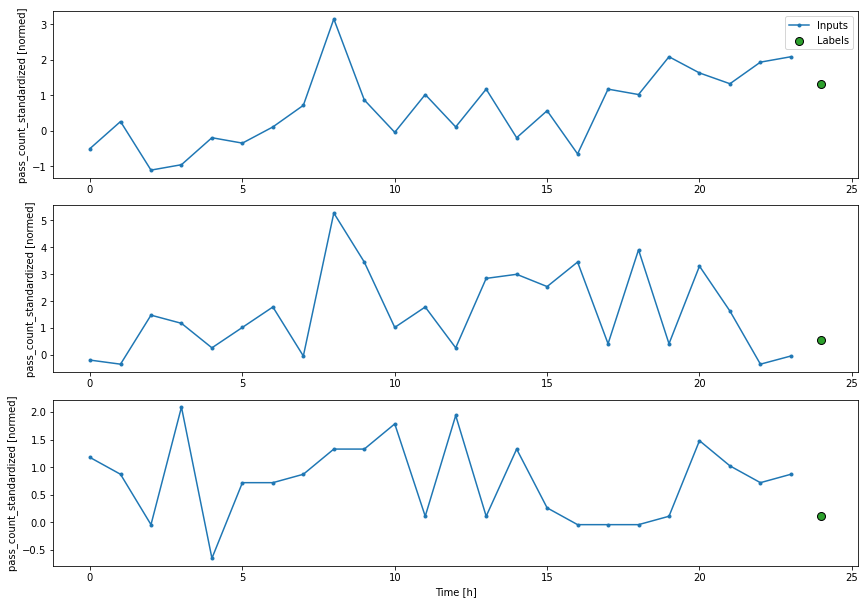

In [23]:
w1.plot()

## Creating a tf.Dataset

In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGeneratorNB.make_dataset = make_dataset

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGeneratorNB.train = train
WindowGeneratorNB.val = val
WindowGeneratorNB.test = test
WindowGeneratorNB.example = example

In [26]:
w1.train.element_spec

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['pass_count_standardized']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['pass_count_standardized']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [27]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

In [28]:
single_step_window = WindowGeneratorNB(
    input_width=1, label_width=1, shift=1,
    label_columns=['pass_count_standardized'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pass_count_standardized']

In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

In [30]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [31]:
baseline = Baseline(label_index=w1.column_indices['pass_count_standardized'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1229/1229 [==============================] - 1s 1ms/step - loss: 1.1311 - mean_absolute_error: 0.7975


In [32]:
wide_window = WindowGeneratorNB(
    input_width=24, label_width=24, shift=1,
    label_columns=['pass_count_standardized'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['pass_count_standardized']

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


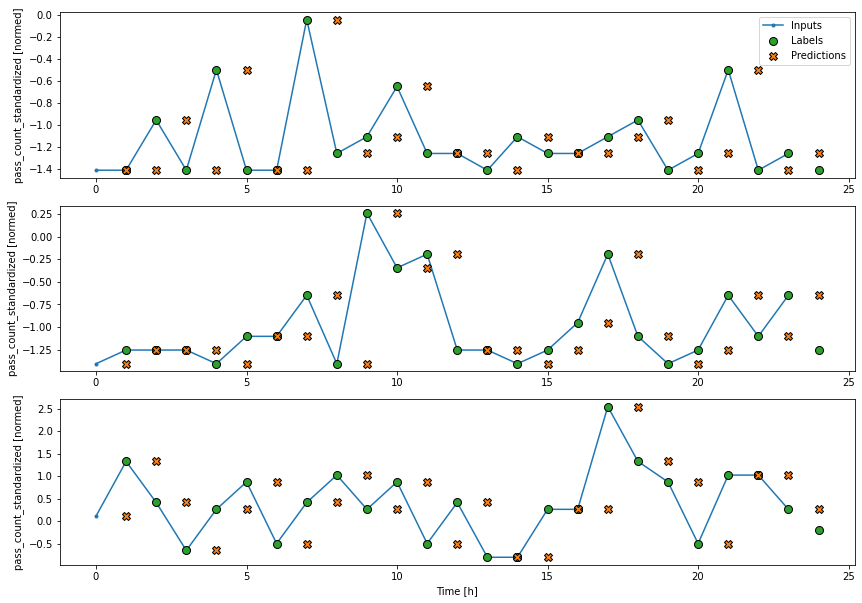

In [34]:
# model where the prediction is the previous value
wide_window.plot(baseline)

## Linear Model

In [35]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [37]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6714 - mean_absolute_error: 0.6268 - val_loss: 0.6143 - val_mean_absolute_error: 0.6043
Epoch 2/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6500 - mean_absolute_error: 0.6160 - val_loss: 0.6144 - val_mean_absolute_error: 0.6046
Epoch 3/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6500 - mean_absolute_error: 0.6160 - val_loss: 0.6143 - val_mean_absolute_error: 0.6045
Epoch 4/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6500 - mean_absolute_error: 0.6159 - val_loss: 0.6141 - val_mean_absolute_error: 0.6045
Epoch 5/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6500 - mean_absolute_error: 0.6160 - val_loss: 0.6143 - val_mean_absolute_error: 0.6045
Epoch 6/20
1229/1229 [==============================] - 2s 1ms/step - loss: 0.6142 - mean_absolute_error: 0.6045


In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


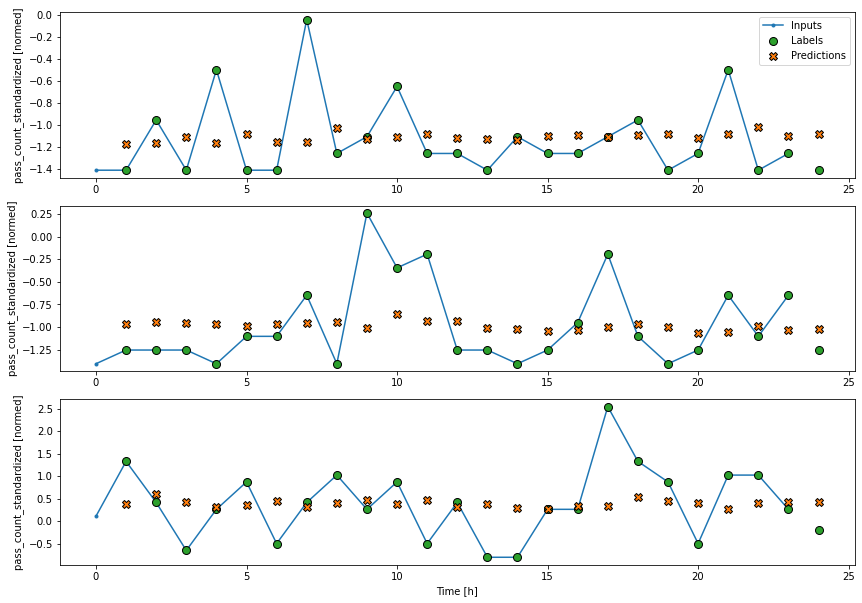

In [39]:
wide_window.plot(linear)

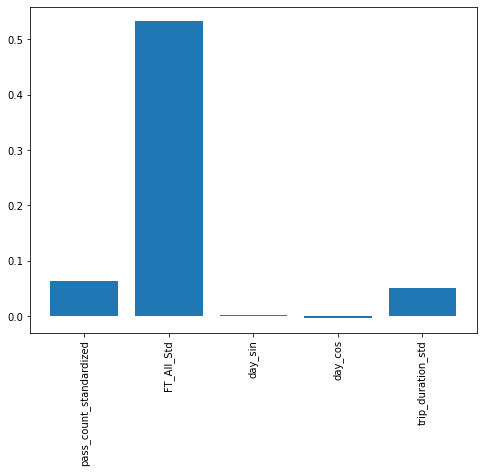

In [40]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense Models

In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 8s 1ms/step - loss: 0.6459 - mean_absolute_error: 0.6141 - val_loss: 0.6151 - val_mean_absolute_error: 0.5973
Epoch 2/20
5733/5733 [==============================] - 7s 1ms/step - loss: 0.6385 - mean_absolute_error: 0.6100 - val_loss: 0.6122 - val_mean_absolute_error: 0.5970
Epoch 3/20
5733/5733 [==============================] - 7s 1ms/step - loss: 0.6367 - mean_absolute_error: 0.6086 - val_loss: 0.6120 - val_mean_absolute_error: 0.5970
Epoch 4/20
5733/5733 [==============================] - 7s 1ms/step - loss: 0.6357 - mean_absolute_error: 0.6079 - val_loss: 0.6114 - val_mean_absolute_error: 0.5966
Epoch 5/20
5733/5733 [==============================] - 7s 1ms/step - loss: 0.6355 - mean_absolute_error: 0.6078 - val_loss: 0.6111 - val_mean_absolute_error: 0.5967
Epoch 6/20
5733/5733 [==============================] - 7s 1ms/step - loss: 0.6351 - mean_absolute_error: 0.6076 - val_loss: 0.6107 - val_mean_absolute_error: 0.5979
Epoc

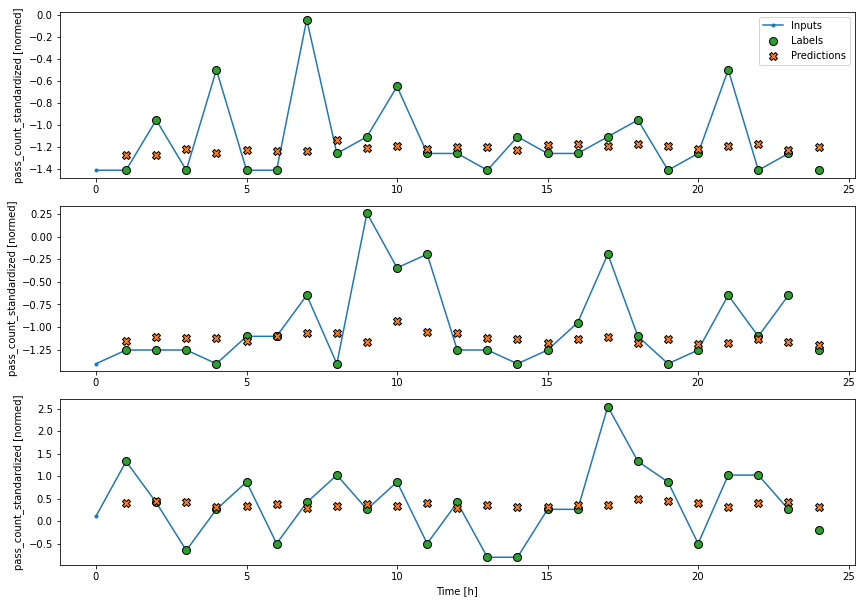

In [42]:
wide_window.plot(dense)

In [43]:
# not needed to train multi-step windows yet

# history = compile_and_fit(dense, wide_window)
# val_performance['Dense_WW'] = dense.evaluate(wide_window.val)
# performance['Dense_WW'] = dense.evaluate(wide_window.test, verbose=0)

## Multi-step dense

In [44]:
CONV_WIDTH = 24
conv_window = WindowGeneratorNB(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['pass_count_standardized'])

conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['pass_count_standardized']

Text(0.5, 1.0, 'Given 24 mins of inputs, predict 1 min into the future.')

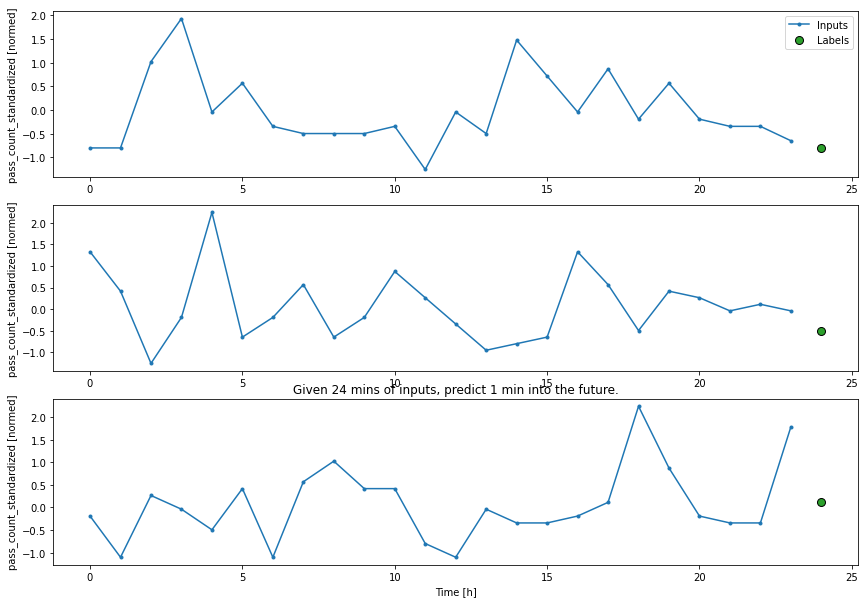

In [45]:
conv_window.plot()
plt.title("Given {} mins of inputs, predict 1 min into the future.".format(CONV_WIDTH))

In [46]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [47]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 1, 1)


In [48]:
history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 9s 1ms/step - loss: 0.6136 - mean_absolute_error: 0.5950 - val_loss: 0.5904 - val_mean_absolute_error: 0.5832
Epoch 2/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6058 - mean_absolute_error: 0.5907 - val_loss: 0.5887 - val_mean_absolute_error: 0.5839
Epoch 3/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6043 - mean_absolute_error: 0.5897 - val_loss: 0.5874 - val_mean_absolute_error: 0.5867
Epoch 4/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6030 - mean_absolute_error: 0.5887 - val_loss: 0.5878 - val_mean_absolute_error: 0.5867
Epoch 5/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6023 - mean_absolute_error: 0.5883 - val_loss: 0.5867 - val_mean_absolute_error: 0.5885
Epoch 6/20
5733/5733 [==============================] - 11s 2ms/step - loss: 0.6017 - mean_absolute_error: 0.5880 - val_loss: 0.5876 - val_mean_absolute_error: 0.5895
E

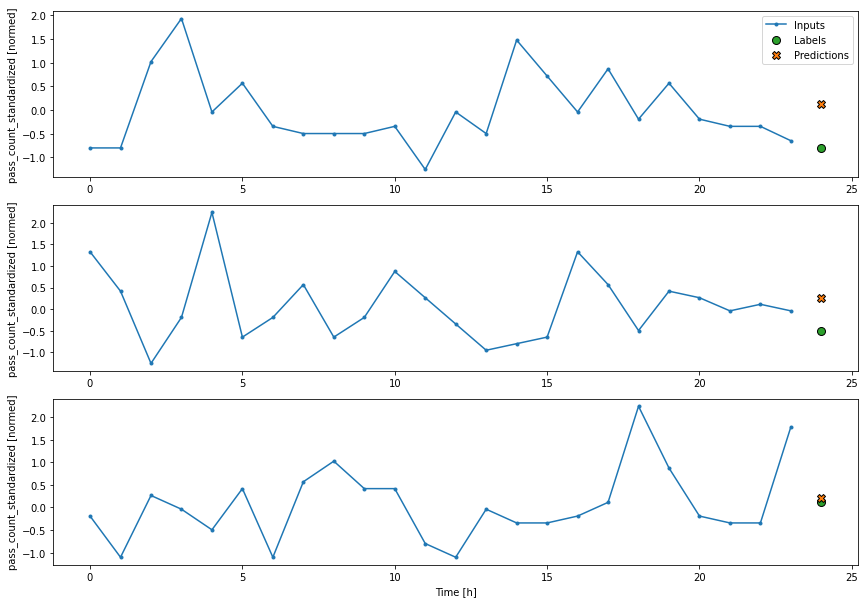

In [49]:
conv_window.plot(multi_step_dense)

## CNNs

In [50]:
CONV_WIDTH

24

In [51]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [52]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 24, 5)
Output shape: (32, 1, 1)


In [53]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 1, 32)               3872      
_________________________________________________________________
dense_7 (Dense)              (32, 1, 32)               1056      
_________________________________________________________________
dense_8 (Dense)              (32, 1, 1)                33        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = compile_and_fit(conv_model, conv_window)

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6104 - mean_absolute_error: 0.5931 - val_loss: 0.5954 - val_mean_absolute_error: 0.5888
Epoch 2/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6053 - mean_absolute_error: 0.5905 - val_loss: 0.5896 - val_mean_absolute_error: 0.5895
Epoch 3/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6039 - mean_absolute_error: 0.5896 - val_loss: 0.5896 - val_mean_absolute_error: 0.5879
Epoch 4/20
5733/5733 [==============================] - 9s 2ms/step - loss: 0.6029 - mean_absolute_error: 0.5891 - val_loss: 0.5884 - val_mean_absolute_error: 0.5868
Epoch 5/20
5733/5733 [==============================] - 10s 2ms/step - loss: 0.6024 - mean_absolute_error: 0.5887 - val_loss: 0.5891 - val_mean_absolute_error: 0.5864
Epoch 6/20
1228/1228 [==============================] - 1s 1ms/step - loss: 0.5887 - mean_absolute_error: 0.5913


In [55]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 1, 1)


In [56]:
LABEL_WIDTH = 5
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGeneratorNB(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['pass_count_standardized'])

wide_conv_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [24 25 26 27 28]
Label column name(s): ['pass_count_standardized']

In [57]:
# NOT NEEDED

# history = compile_and_fit(conv_model, wide_conv_window)

# # IPython.display.clear_output()
# val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
# performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

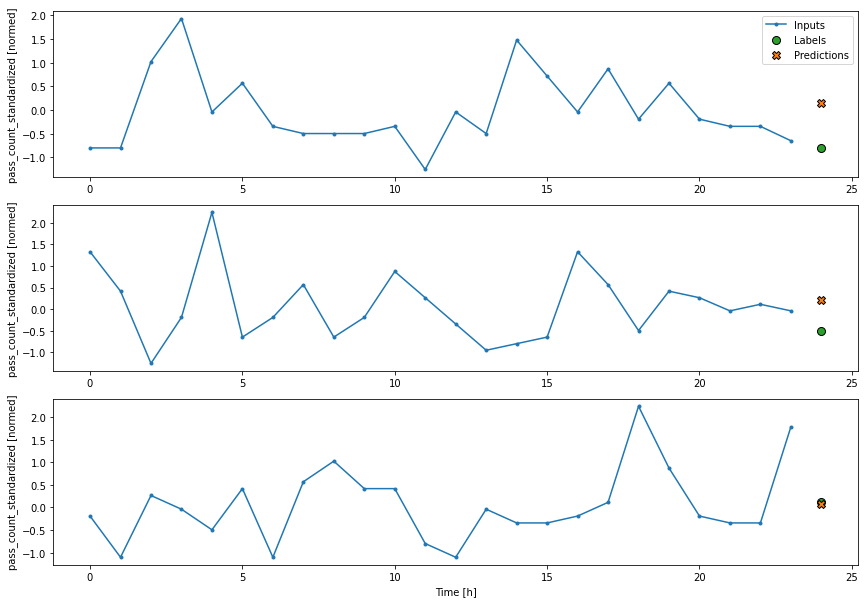

In [58]:
conv_window.plot(conv_model)

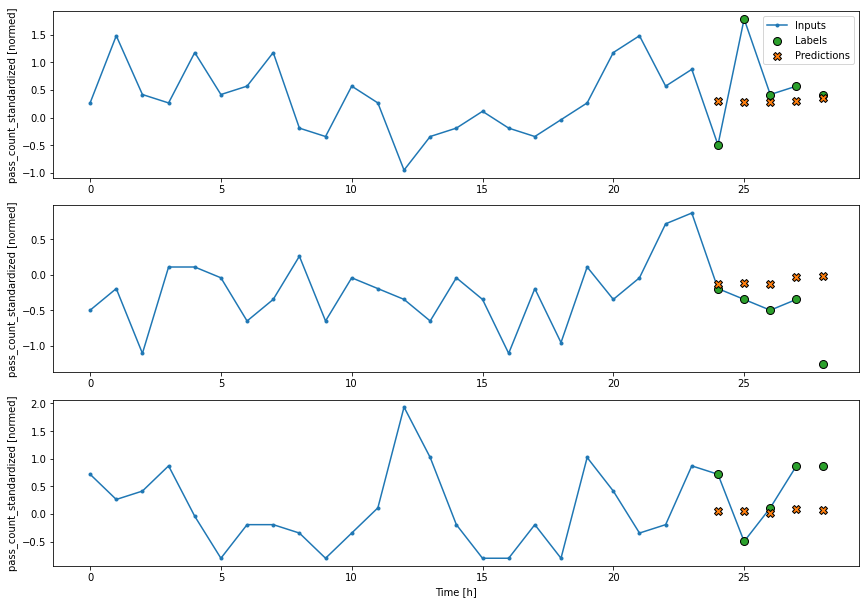

In [59]:
wide_conv_window.plot(conv_model)

## RNNs

In [60]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [61]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['pass_count_standardized']

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 35s 6ms/step - loss: 0.6129 - mean_absolute_error: 0.5946 - val_loss: 0.5921 - val_mean_absolute_error: 0.5927
Epoch 2/20
5733/5733 [==============================] - 35s 6ms/step - loss: 0.6084 - mean_absolute_error: 0.5917 - val_loss: 0.5911 - val_mean_absolute_error: 0.5898
Epoch 3/20
5733/5733 [==============================] - 42s 7ms/step - loss: 0.6072 - mean_absolute_error: 0.5911 - val_loss: 0.5925 - val_mean_absolute_error: 0.5914
Epoch 4/20
1228/1228 [==============================] - 3s 2ms/step - loss: 0.5926 - mean_absolute_error: 0.5910


In [64]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            4864      
_________________________________________________________________
dense_9 (Dense)              (None, 24, 1)             33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


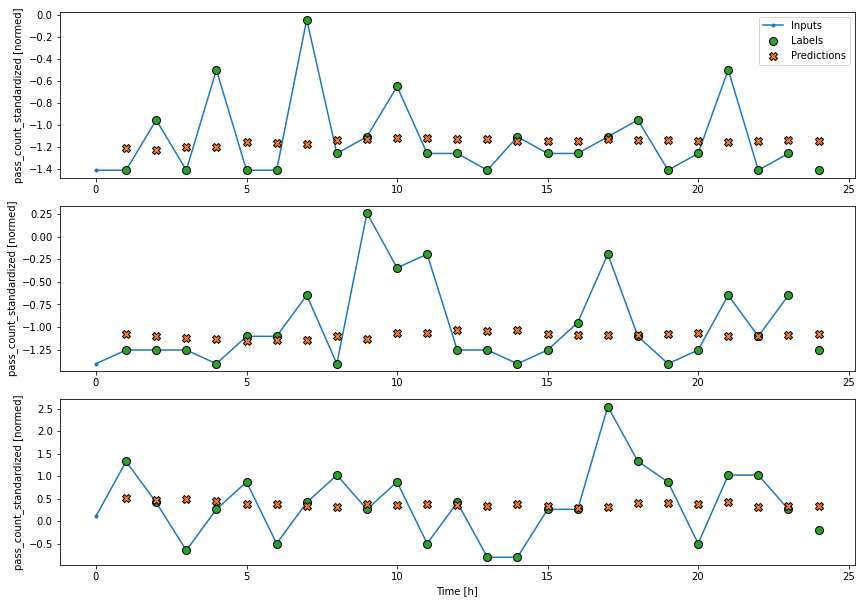

In [65]:
wide_window.plot(lstm_model)

In [66]:
print('Input shape:', wide_conv_window.example[0].shape)
print('Output shape:', lstm_model(wide_conv_window.example[0]).shape)

Input shape: (32, 28, 5)
Output shape: (32, 28, 1)


In [67]:
wide_conv_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [24 25 26 27 28]
Label column name(s): ['pass_count_standardized']

In [68]:
# MAX_EPOCHS = 20

# def compile_and_fit(model, window, patience=2):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#   model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.optimizers.Adam(),
#                 metrics=[tf.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
#   return history

In [81]:
wide_window.train

<MapDataset shapes: ((None, 24, 5), (None, 24, 1)), types: (tf.float32, tf.float32)>

In [78]:
single_step_window.train

<MapDataset shapes: ((None, 1, 5), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [76]:
wide_conv_window.train

<MapDataset shapes: ((None, 28, 5), (None, 5, 1)), types: (tf.float32, tf.float32)>

In [82]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4864      
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [69]:
lstm_conv_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=5)
])

In [70]:
history = compile_and_fit(lstm_conv_model, wide_conv_window)

# IPython.display.clear_output()
val_performance['LSTMCONV'] = lstm_conv_model.evaluate(wide_conv_window.val)
performance['LSTMCONV'] = lstm_conv_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/20
5733/5733 [==============================] - 49s 9ms/step - loss: 0.1515 - mean_absolute_error: 0.1774 - val_loss: 0.1180 - val_mean_absolute_error: 0.1351
Epoch 2/20
5733/5733 [==============================] - 52s 9ms/step - loss: 0.1216 - mean_absolute_error: 0.1339 - val_loss: 0.1173 - val_mean_absolute_error: 0.1320
Epoch 3/20
5733/5733 [==============================] - 48s 8ms/step - loss: 0.1211 - mean_absolute_error: 0.1316 - val_loss: 0.1178 - val_mean_absolute_error: 0.1336
Epoch 4/20
5733/5733 [==============================] - 47s 8ms/step - loss: 0.1209 - mean_absolute_error: 0.1306 - val_loss: 0.1171 - val_mean_absolute_error: 0.1267
Epoch 5/20
5733/5733 [==============================] - 47s 8ms/step - loss: 0.1208 - mean_absolute_error: 0.1298 - val_loss: 0.1170 - val_mean_absolute_error: 0.1277
Epoch 6/20
5733/5733 [==============================] - 47s 8ms/step - loss: 0.1206 - mean_absolute_error: 0.1291 - val_loss: 0.1172 - val_mean_absolute_error: 0.130

In [75]:
lstm_conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 5,029
Trainable params: 5,029
Non-trainable params: 0
_________________________________________________________________


In [72]:
wide_conv_window.train_df

pass_count_standardized  FT_All_Std       day_sin   day_cos  \
0                     -0.495907    0.400026 -2.008887e-10  1.000000   
1                      0.263713    0.388426  2.588190e-01  0.965926   
2                     -1.103604    0.376811  5.000000e-01  0.866025   
3                     -0.951680    0.365181  7.071068e-01  0.707107   
4                     -0.192059    0.353538  8.660254e-01  0.500000   
...                         ...         ...           ...       ...   
183451                 0.111789   -0.347738 -9.659258e-01  0.258819   
183452                 0.719485   -0.344934 -8.660254e-01  0.500000   
183453                 1.023333   -0.342158 -7.071068e-01  0.707107   
183454                -0.495907   -0.339408 -5.000000e-01  0.866025   
183455                 0.415637   -0.336681 -2.588190e-01  0.965926   

        trip_duration_std  
0               -0.739953  
1               -0.359686  
2               -0.852496  
3               -0.660477  
4               -0.987083  
...                   ...  
183451           0.259300  
183452           0.337616  
183453           0.640437  
183454          -0.842054  
183455          -0.324879  

[183456 rows x 5 columns]

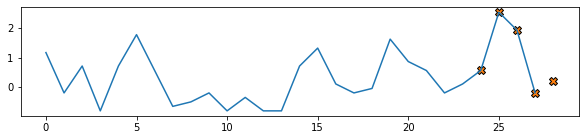

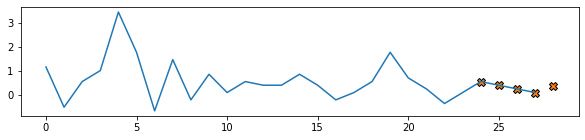

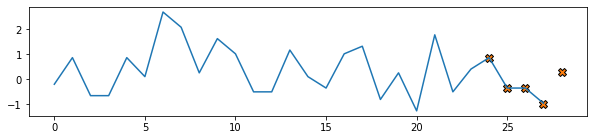

In [73]:
for n in range(20,23):
    plt.figure(figsize=(10,2))
    plt.plot(wide_conv_window.input_indices, wide_conv_window.example[0][n,:,0])
    plt.scatter(wide_conv_window.label_indices, lstm_conv_model(wide_conv_window.example[0])[n],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

In [91]:
lstm_conv_model(wide_conv_window.example[0])

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[-0.49596536,  1.7892077 ,  0.41874367,  0.5646186 ,  0.35731292],
       [-0.1793468 , -0.33907482, -0.50236464, -0.3461714 , -0.03844719],
       [ 0.70940953, -0.48305637,  0.10502546,  0.85981476,  0.12301262],
       [ 2.8525906 ,  1.3309064 ,  0.567917  , -0.6455733 ,  0.32793027],
       [ 0.72075593, -0.04859851,  1.911619  , -0.35480738,  0.41703752],
       [-0.064373  ,  0.10848244, -0.3474215 , -0.04296029, -0.06667285],
       [ 1.0121019 , -0.352375  , -0.04119813,  0.8653456 ,  0.17426556],
       [ 0.87601423, -0.18963215,  0.5644218 ,  0.11238465,  0.39833856],
       [ 2.5061338 , -0.46278712,  1.0554537 ,  2.5500033 ,  0.7105176 ],
       [-0.827472  ,  0.549566  , -0.80710983,  0.25480038, -0.34044963],
       [-1.4295653 , -1.4225705 , -1.2779194 , -1.2706368 , -1.2068982 ],
       [ 0.39101243,  1.6086605 , -0.0444871 ,  0.41225857,  0.253732  ],
       [-1.4118083 , -1.2621489 , -1.4295341 , -1.4110005 , -1.

In [77]:
wide_conv_window.example[0][n,:,0]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([-0.19205922,  0.8714094 , -0.6478315 , -0.6478315 ,  0.8714094 ,
        0.11178895,  2.6944985 ,  2.086802  ,  0.26371303,  1.6310298 ,
        1.0233334 , -0.4959074 , -0.4959074 ,  1.1752576 ,  0.11178895,
       -0.34398332,  1.0233334 ,  1.3271817 , -0.7997556 ,  0.26371303,
       -1.2555279 ,  1.7829539 , -0.4959074 ,  0.41563714,  0.8714094 ,
       -0.34398332, -0.34398332, -0.95167965], dtype=float32)>

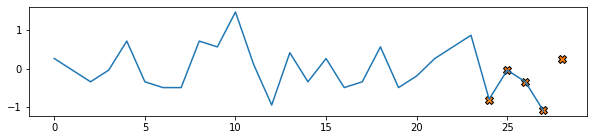

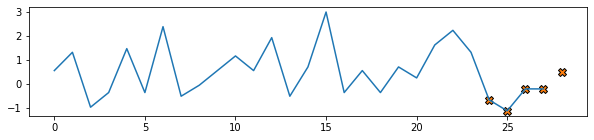

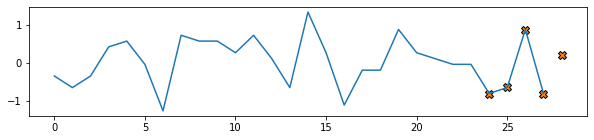

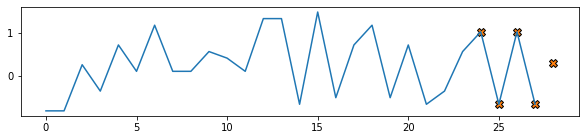

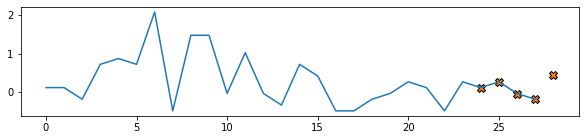

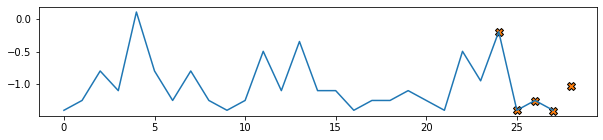

In [93]:
for i, element in enumerate(wide_conv_window.test):
    plt.figure(figsize=(10,2))
    plt.plot(wide_conv_window.input_indices, element[0][i,:,0])
    plt.scatter(wide_conv_window.label_indices, lstm_conv_model(element[0])[i],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
    if i == 5:
        break

## Residual connections

In [94]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [96]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        5,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

# IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

Epoch 1/20
5733/5733 [==============================] - 40s 7ms/step - loss: 0.6280 - mean_absolute_error: 0.6015 - val_loss: 0.5925 - val_mean_absolute_error: 0.5903
Epoch 2/20
5733/5733 [==============================] - 46s 8ms/step - loss: 0.6105 - mean_absolute_error: 0.5930 - val_loss: 0.5946 - val_mean_absolute_error: 0.5962
Epoch 3/20
5733/5733 [==============================] - 54s 9ms/step - loss: 0.6094 - mean_absolute_error: 0.5922 - val_loss: 0.5909 - val_mean_absolute_error: 0.5892
Epoch 4/20
5733/5733 [==============================] - 48s 8ms/step - loss: 0.6085 - mean_absolute_error: 0.5918 - val_loss: 0.5916 - val_mean_absolute_error: 0.5902
Epoch 5/20
1228/1228 [==============================] - 4s 3ms/step - loss: 0.5916 - mean_absolute_error: 0.5910

Wall time: 4min 7s


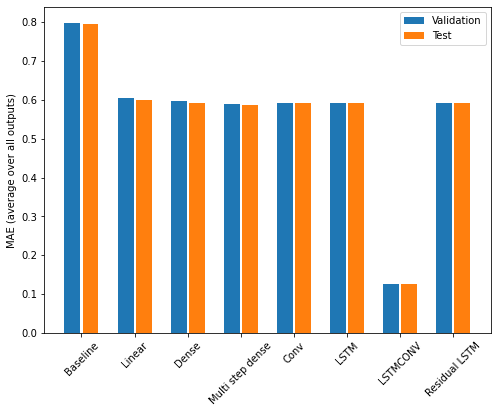

In [97]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [98]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.7937
Linear         : 0.5997
Dense          : 0.5906
Multi step dense: 0.5870
Conv           : 0.5901
LSTM           : 0.5910
LSTMCONV       : 0.1265
Residual LSTM  : 0.5904


## Multistep models
Also shown above with the wide_conv_window and the lstm_conv_model

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

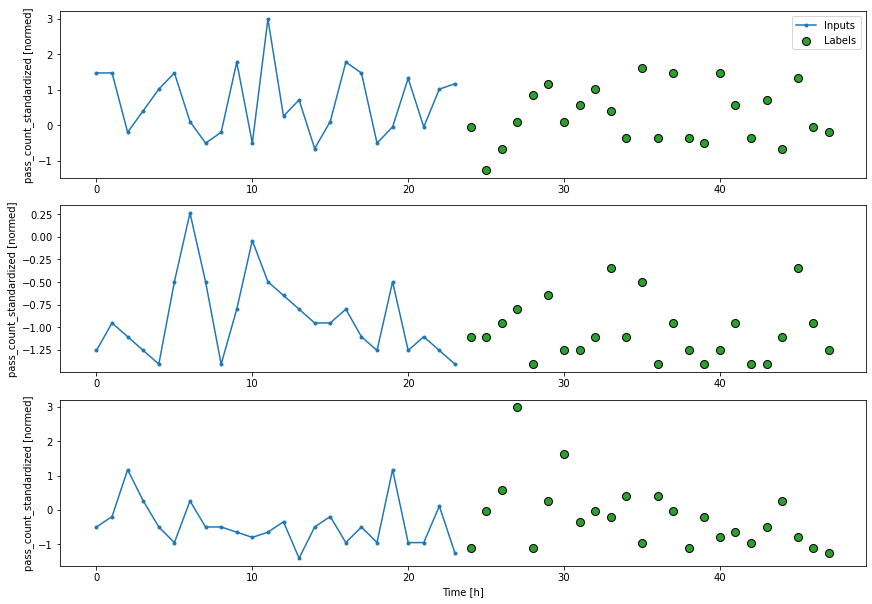

In [110]:
OUT_STEPS = 24
multi_window = WindowGeneratorNB(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1228/1228 [==============================] - 1s 1ms/step - loss: 0.8680 - mean_absolute_error: 0.6593


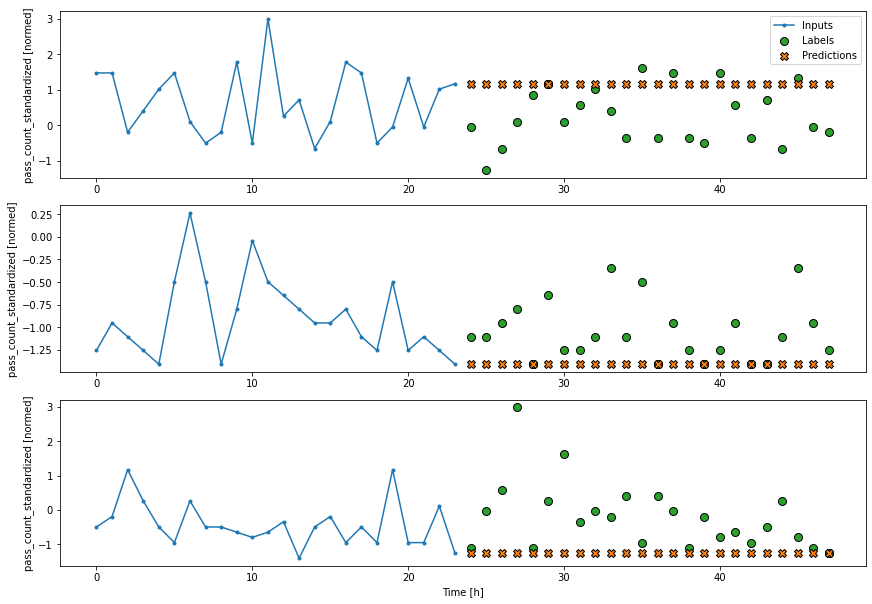

In [111]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [112]:
multi_window.train

<MapDataset shapes: ((None, 24, 5), (None, 24, 5)), types: (tf.float32, tf.float32)>

1228/1228 [==============================] - 1s 995us/step - loss: 0.4764 - mean_absolute_error: 0.3504


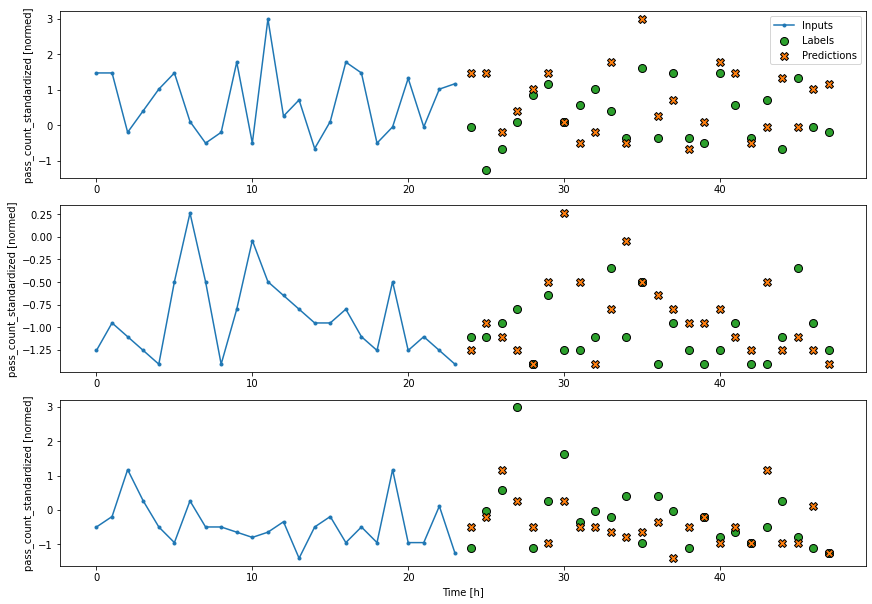

In [113]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single shot models

In [114]:
num_features=5

Epoch 1/20
5732/5732 [==============================] - 8s 1ms/step - loss: 0.2817 - mean_absolute_error: 0.3004 - val_loss: 0.2644 - val_mean_absolute_error: 0.2596
Epoch 2/20
5732/5732 [==============================] - 7s 1ms/step - loss: 0.2540 - mean_absolute_error: 0.2548 - val_loss: 0.2644 - val_mean_absolute_error: 0.2596
Epoch 3/20
5732/5732 [==============================] - 8s 1ms/step - loss: 0.2540 - mean_absolute_error: 0.2548 - val_loss: 0.2644 - val_mean_absolute_error: 0.2596
Epoch 4/20
1228/1228 [==============================] - 2s 2ms/step - loss: 0.2644 - mean_absolute_error: 0.2596


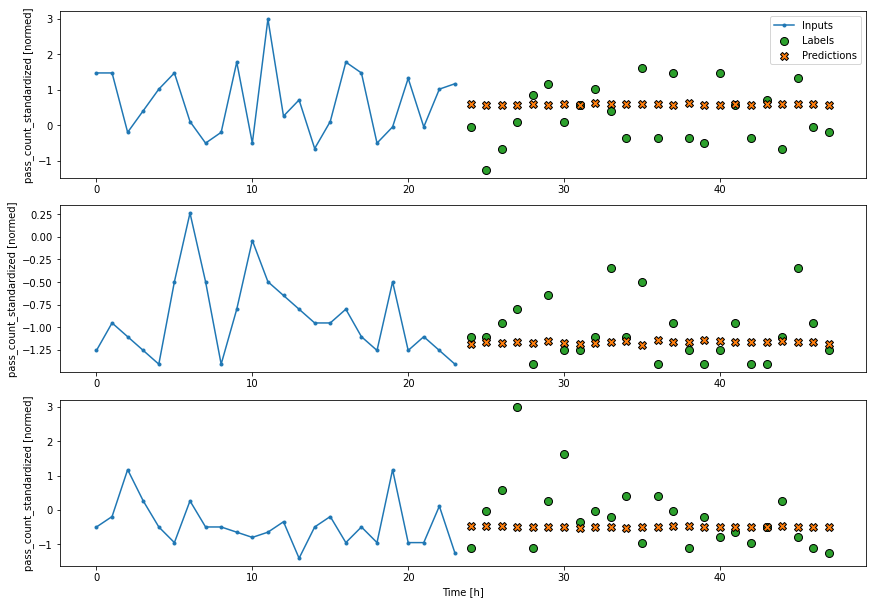

In [115]:
# Linear
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
5732/5732 [==============================] - 16s 3ms/step - loss: 0.2524 - mean_absolute_error: 0.2611 - val_loss: 0.2621 - val_mean_absolute_error: 0.2642
Epoch 2/20
5732/5732 [==============================] - 17s 3ms/step - loss: 0.2480 - mean_absolute_error: 0.2565 - val_loss: 0.2611 - val_mean_absolute_error: 0.2644
Epoch 3/20
5732/5732 [==============================] - 15s 3ms/step - loss: 0.2474 - mean_absolute_error: 0.2556 - val_loss: 0.2608 - val_mean_absolute_error: 0.2617
Epoch 4/20
5732/5732 [==============================] - 18s 3ms/step - loss: 0.2472 - mean_absolute_error: 0.2550 - val_loss: 0.2603 - val_mean_absolute_error: 0.2611
Epoch 5/20
5732/5732 [==============================] - 15s 3ms/step - loss: 0.2471 - mean_absolute_error: 0.2548 - val_loss: 0.2604 - val_mean_absolute_error: 0.2611
Epoch 6/20
5732/5732 [==============================] - 14s 3ms/step - loss: 0.2470 - mean_absolute_error: 0.2544 - val_loss: 0.2603 - val_mean_absolute_error: 0.261

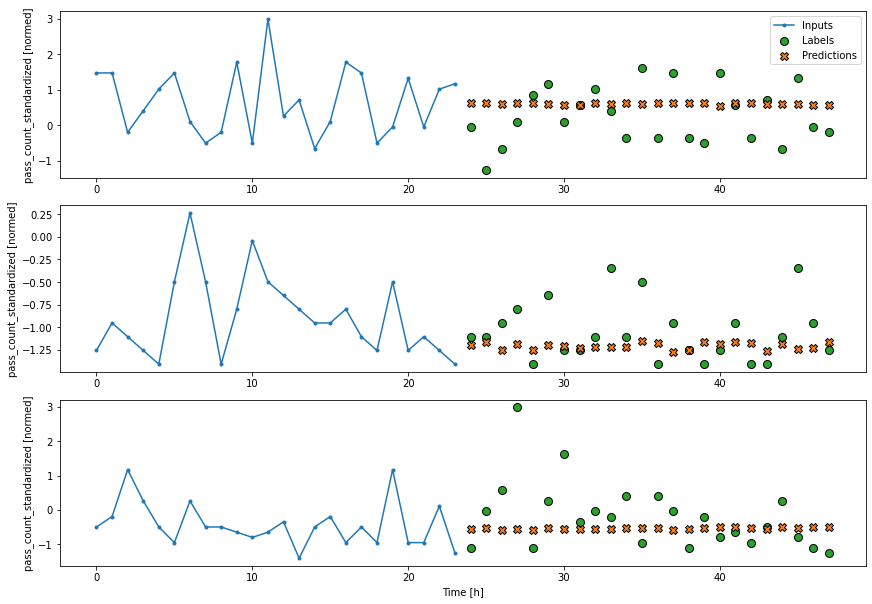

In [116]:
# Dense
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## CNN

Epoch 1/20
5732/5732 [==============================] - 11s 2ms/step - loss: 0.2462 - mean_absolute_error: 0.2589 - val_loss: 0.2560 - val_mean_absolute_error: 0.2630
Epoch 2/20
5732/5732 [==============================] - 14s 3ms/step - loss: 0.2418 - mean_absolute_error: 0.2532 - val_loss: 0.2542 - val_mean_absolute_error: 0.2574
Epoch 3/20
5732/5732 [==============================] - 12s 2ms/step - loss: 0.2401 - mean_absolute_error: 0.2486 - val_loss: 0.2531 - val_mean_absolute_error: 0.2560
Epoch 4/20
5732/5732 [==============================] - 11s 2ms/step - loss: 0.2392 - mean_absolute_error: 0.2461 - val_loss: 0.2530 - val_mean_absolute_error: 0.2546
Epoch 5/20
5732/5732 [==============================] - 12s 2ms/step - loss: 0.2389 - mean_absolute_error: 0.2453 - val_loss: 0.2526 - val_mean_absolute_error: 0.2526
Epoch 6/20
5732/5732 [==============================] - 12s 2ms/step - loss: 0.2387 - mean_absolute_error: 0.2445 - val_loss: 0.2525 - val_mean_absolute_error: 0.252

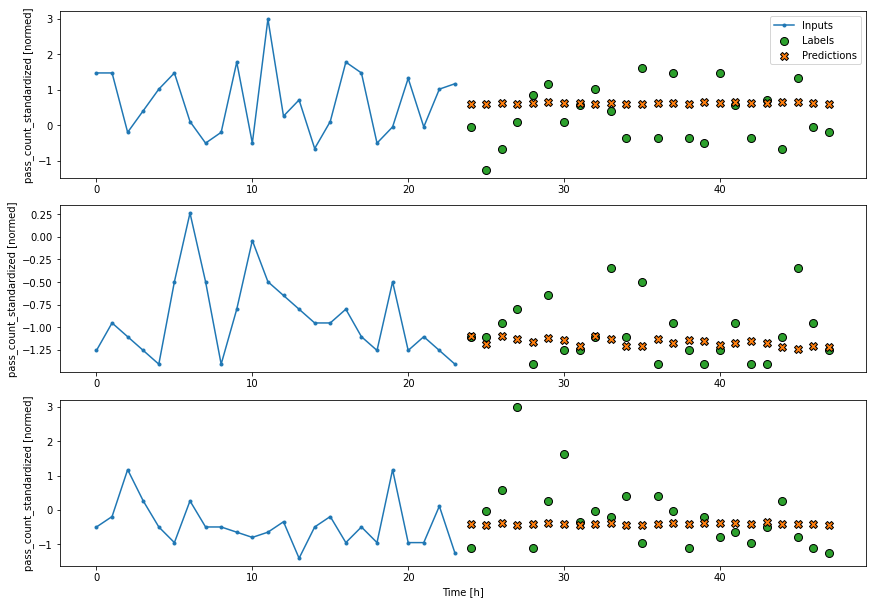

In [117]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

Epoch 1/20
5732/5732 [==============================] - 38s 7ms/step - loss: 0.2395 - mean_absolute_error: 0.2582 - val_loss: 0.2420 - val_mean_absolute_error: 0.2504
Epoch 2/20
5732/5732 [==============================] - 39s 7ms/step - loss: 0.2293 - mean_absolute_error: 0.2392 - val_loss: 0.2417 - val_mean_absolute_error: 0.2477
Epoch 3/20
5732/5732 [==============================] - 54s 9ms/step - loss: 0.2289 - mean_absolute_error: 0.2373 - val_loss: 0.2412 - val_mean_absolute_error: 0.2464
Epoch 4/20
5732/5732 [==============================] - 52s 9ms/step - loss: 0.2287 - mean_absolute_error: 0.2362 - val_loss: 0.2412 - val_mean_absolute_error: 0.2455
Epoch 5/20
5732/5732 [==============================] - 49s 9ms/step - loss: 0.2285 - mean_absolute_error: 0.2354 - val_loss: 0.2411 - val_mean_absolute_error: 0.2439
Epoch 6/20
5732/5732 [==============================] - 51s 9ms/step - loss: 0.2283 - mean_absolute_error: 0.2348 - val_loss: 0.2409 - val_mean_absolute_error: 0.244

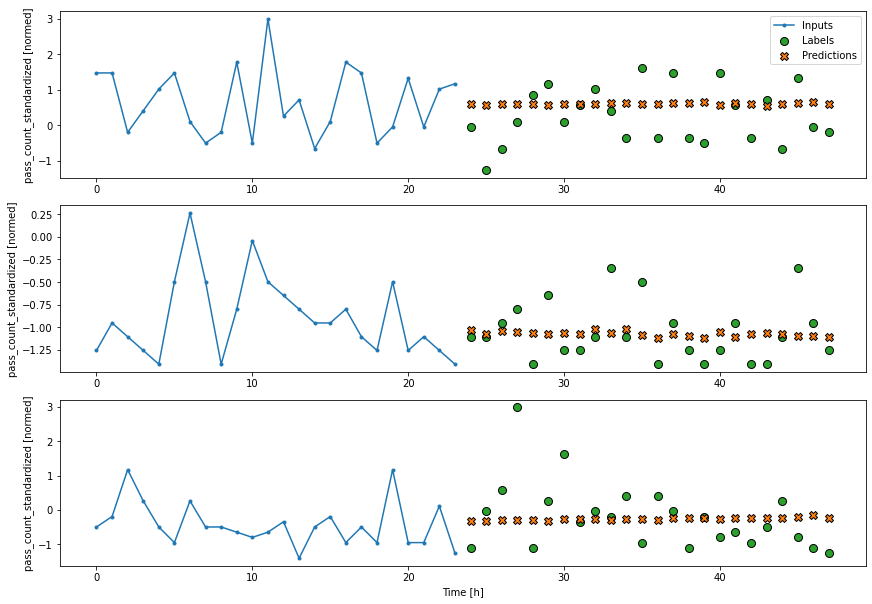

In [118]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## RNN Advanced Auto-regressive Model

In [119]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [120]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [121]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [122]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [123]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [124]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 5)


Epoch 1/20
5732/5732 [==============================] - 54s 9ms/step - loss: 0.2369 - mean_absolute_error: 0.2556 - val_loss: 0.2433 - val_mean_absolute_error: 0.2552
Epoch 2/20
5732/5732 [==============================] - 66s 11ms/step - loss: 0.2298 - mean_absolute_error: 0.2426 - val_loss: 0.2421 - val_mean_absolute_error: 0.2500
Epoch 3/20
5732/5732 [==============================] - 73s 13ms/step - loss: 0.2294 - mean_absolute_error: 0.2412 - val_loss: 0.2419 - val_mean_absolute_error: 0.2499
Epoch 4/20
5732/5732 [==============================] - 67s 12ms/step - loss: 0.2291 - mean_absolute_error: 0.2403 - val_loss: 0.2414 - val_mean_absolute_error: 0.2465
Epoch 5/20
5732/5732 [==============================] - 68s 12ms/step - loss: 0.2289 - mean_absolute_error: 0.2396 - val_loss: 0.2412 - val_mean_absolute_error: 0.2470
Epoch 6/20
5732/5732 [==============================] - 68s 12ms/step - loss: 0.2287 - mean_absolute_error: 0.2388 - val_loss: 0.2415 - val_mean_absolute_error: 

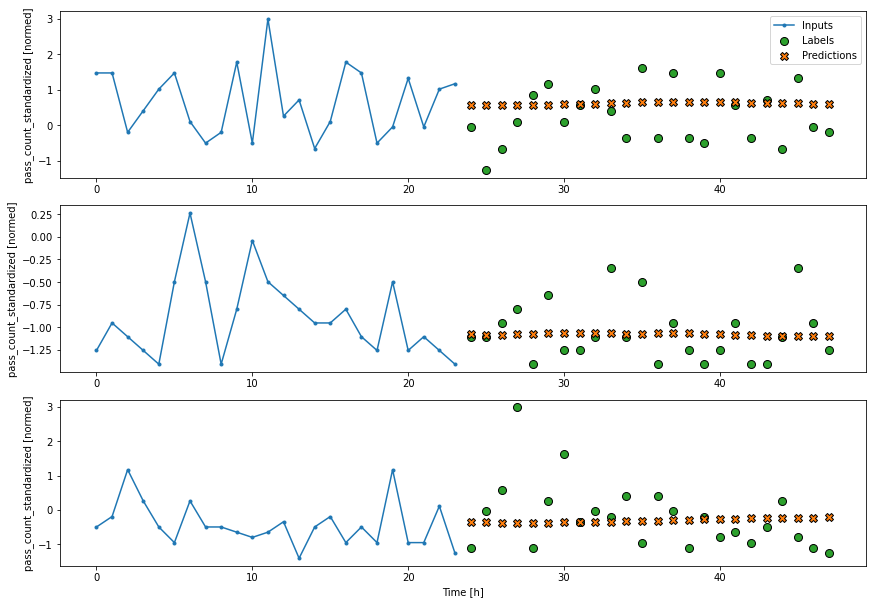

In [125]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

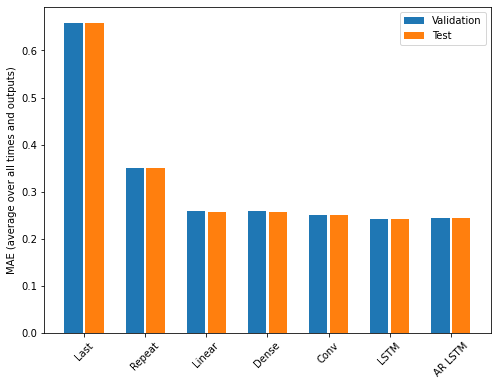

In [126]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [127]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.6586
Repeat  : 0.3497
Linear  : 0.2562
Dense   : 0.2564
Conv    : 0.2497
LSTM    : 0.2418
AR LSTM : 0.2452
